In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

## Step 1 - Climate Analysis and Exploration

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
Base = automap_base()

Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
session = Session(engine)

In [8]:
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

print("-----")
    
columns2 = inspector.get_columns('measurement')
for column2 in columns2:
    print(column2["name"], column2["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


### Precipitation Analysis

###### Design a query to retrieve the last 12 months of precipitation data and plot the results.

In [9]:
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23')]

In [10]:
prcp_12_months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

In [11]:
prcp_12_months_df = pd.DataFrame(prcp_12_months)
prcp_12_months_df = prcp_12_months_df.dropna()
prcp_12_months_df = prcp_12_months_df.sort_values(by = "date")
prcp_12_months_df = prcp_12_months_df.set_index("date")

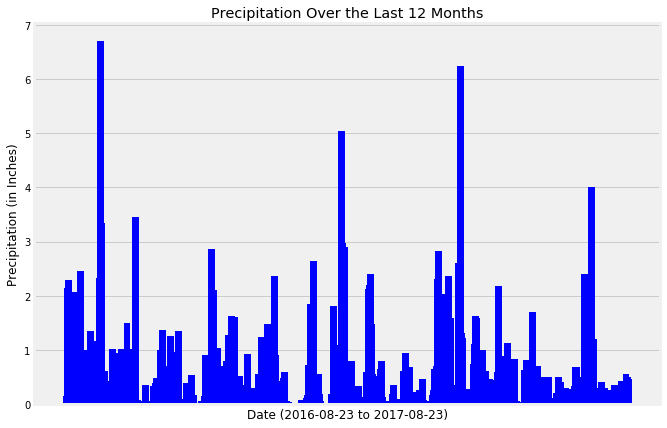

In [12]:
plt.figure(figsize=(10,7))

precipitation = prcp_12_months_df["prcp"]

N = len(prcp_12_months_df.index.tolist())
ind = np.arange(N)
width = 25   
  
plt.bar(ind, precipitation, width, color="blue")

plt.title("Precipitation Over the Last 12 Months")
plt.ylabel("Precipitation (in Inches)")
plt.xlabel("Date (2016-08-23 to 2017-08-23)")
plt.xticks([], [])

plt.show()

In [13]:
prcp_12_months_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

###### Design a query to show how many stations are available in this dataset.

In [14]:
number = session.query(Station.station).count()

print("There is a total of " + str(number) + " stations.")

There is a total of 9 stations.


###### What are the most active stations? (i.e. what stations have the most rows)? List the stations and the counts in descending order.

In [15]:
count = func.count(Measurement.station)

session.query(Measurement.station, count).\
    group_by(Measurement.station).\
    order_by(count.desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

###### Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?

In [16]:
most_active = session.query(Measurement.station, count).\
    group_by(Measurement.station).\
    order_by(count.desc()).all()[0][0]

print("Station " + str(most_active) + " has the highest number of observations.")

Station USC00519281 has the highest number of observations.


In [17]:
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

###### Choose the station with the highest number of temperature observations. Query the last 12 months of temperature observation data for this station and plot the results as a histogram.

In [18]:
MA_tobs_12_months = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= "2016-08-23").\
    order_by(Measurement.tobs).all()

tobs = pd.DataFrame(MA_tobs_12_months)

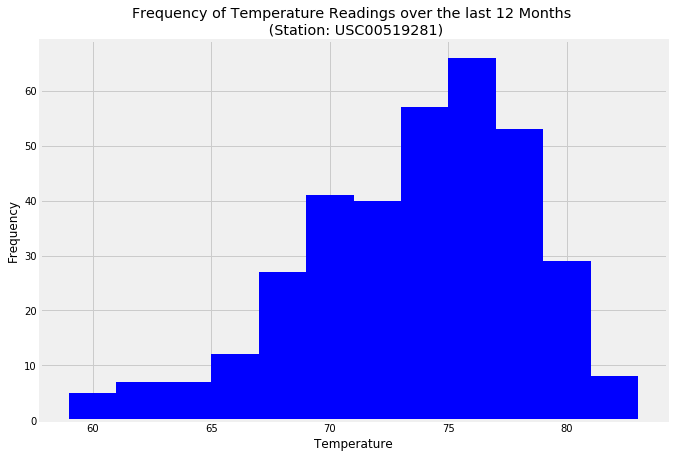

In [19]:
plt.figure(figsize=(10,7))

plt.hist(tobs["tobs"], bins=12, color="blue")

plt.title("Frequency of Temperature Readings over the last 12 Months \n (Station: "
          + str(most_active) + ")")
plt.ylabel("Frequency")
plt.xlabel("Temperature")

plt.show()

## Temperature Analysis

###### Calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year. Plot the min, avg, and max temperature from your previous query as a bar chart (use the average temperature as the bar height & the peak-to-peak (tmax-tmin) value as the y error bar (yerr)). 

In [20]:
def calc_temps(start_date, end_date):
       return session.query(func.min(Measurement.tobs),\
                         func.avg(Measurement.tobs), \
                         func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()

#### trip date (7 days): 
    - start = 2018-08-09 
    - end = 2018-08-16

In [21]:
ly_temps = calc_temps("2017-08-09", "2017-08-16")

print("Last years min, avg, & max temperatures: " + str(ly_temps))

Last years min, avg, & max temperatures: [(70.0, 78.36363636363636, 84.0)]


In [22]:
ly_min = ly_temps[0][0]
ly_avg = ly_temps[0][1]
ly_max = ly_temps[0][2]

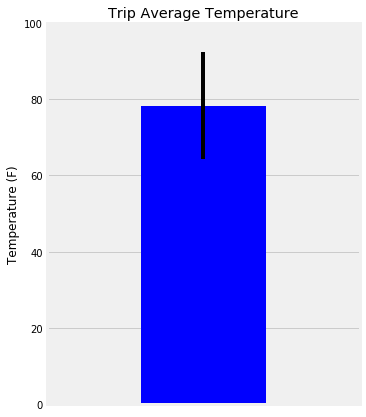

In [23]:
plt.figure(figsize=(5,7))

plt.bar(0, ly_avg, color = "blue", yerr = ly_max - ly_min)

plt.title("Trip Average Temperature")
plt.ylabel("Temperature (F)")
plt.xticks([], [])
plt.ylim(0, 100)
plt.xlim(-1 , 1)

plt.show()